Instalacja środowiska CUDA

In [ ]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

!nvcc --version

Ładowanie rozszerzenia

In [ ]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-4kourdec
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-4kourdec
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4305 sha256=ea1d92d8470ee387c1f42ce283048a9342d192e8106644a5e6ccf5fdd575c712
  Stored in directory: /tmp/pip-ephem-wheel-cache-t_2qspwu/wheels/c5/2b/c0/87008e795a14bbcdfc7c846a00d06981916331eb980b6c8bdf
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


Test

In [ ]:
%%cu
#include <iostream>
    int main()
{
    std::cout << "Hello from Google Colab!\n";
    return 0;
}

Hello from Google Colab!



**Liczenie zbioru Mandelbrota na CPU**

In [ ]:
%%cu
#include <chrono>  // obsługa mierzenia czasu w C++
#include <iostream> 
#include <vector>

int cpuMandelbrot(double X0, double Y0, double X1, double Y1, int POZ, int PION, int ITER,int *Mandel ){
    double dx=(X1-X0)/POZ;
    double dy=(Y1-Y0)/PION;
    for (int r_y = 0; r_y<PION; r_y++)
    {
        // Punkt w pionie na płaszczyznie zespolonej
        double c_y0 = Y1 - r_y * dy;

        for(int r_x = 0; r_x<POZ; r_x++)
        {
            // Punkt w poziomie na płaszczyznie zespolonej
            double c_x0 = X0 + r_x * dx;

            double x = 0.0;
            double y = 0.0;
            int iteracji = 0;

            while (x*x + y*y < 2*2 && iteracji < ITER) {
                double xtemp = x*x - y*y + c_x0;
                y = 2*x*y + c_y0;
                x = xtemp;
                iteracji += 1;
            };
            
            Mandel[r_y*POZ+r_x] = iteracji;
        }

    }
    return 1;
}

int main() {
  //Ustaw obszar obliczen
  //{X0,Y0} - lewy dolny rog
  double X0=atof("-1.");
  double Y0=atof("-1.");

  //{X1,Y1} - prawy gorny rog
  double X1=atof("1.");
  double Y1=atof("1.");

  //Ustal rozmiar w pikselach
  //{POZ,PION}
  int POZ=atoi("3000");
  int PION=atoi("3000");

  //Ustal liczbe iteracji probkowania
  int ITER=atoi("256");

  // Zaalokuj tablice do przechowywania wyniku na CPU
  int *host_mandel = (int *) malloc(sizeof(int)*POZ*PION);

  int num_of_executions = 25;

  // Zdefiniuj timery
  time_t start, end;

  std::vector<double> cpu_durations = { };

  std::chrono::duration<int64_t, std::nano> diff;
 
  for (int i = 0; i < num_of_executions; i++) {
    // startujemy pomiar czasu - na rózne sposoby
    start=clock();
    auto start2 = std::chrono::steady_clock::now();

    cpuMandelbrot(X0,Y0,X1,Y1,POZ,PION,ITER,host_mandel);

    // konczymy pomiar czasu 
    auto stop = std::chrono::steady_clock::now();
    end=clock();
    diff = stop - start2;
    cpu_durations.push_back(((double) diff.count() / 1000000000)); // Nanosekundy do sekund      
  }

  std::cout << "CPU" << std::endl;
  std::string cpu_string_result = "";
  for (float result : cpu_durations) {
    cpu_string_result.append(std::to_string(result) + ", ");
  }
  std::cout << cpu_string_result << std::endl;

 
 return 0;
}


CPU
7.175024, 7.112954, 7.181449, 7.162680, 7.131800, 7.129289, 7.136329, 7.175058, 7.149242, 7.141355, 7.104564, 7.140340, 7.115874, 7.136297, 7.148814, 7.149102, 7.135401, 7.167239, 7.151696, 7.152233, 7.163439, 7.143386, 7.163455, 7.156902, 7.156501, 



Wynikiem uruchomienia powyższego kodu na CPU jest następująca sekwencja (oczywiście będzie się minimalnie różnić przy każdym uruchomieniu)
```
[7.175024, 7.112954, 7.181449, 7.162680, 7.131800, 7.129289, 7.136329, 7.175058, 7.149242, 7.141355, 7.104564, 7.140340, 7.115874, 7.136297, 7.148814, 7.149102, 7.135401, 7.167239, 7.151696, 7.152233, 7.163439, 7.143386, 7.163455, 7.156902, 7.156501]
```
Możemy ją zwizualizować


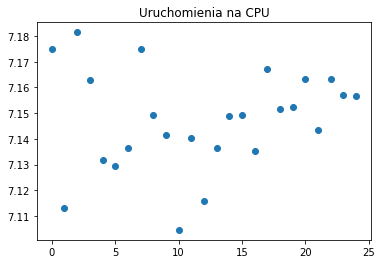



Średnia 7.147216919999998
Odchylenie standardowe 0.019111113840736733
Min 7.104564
Max 7.181449


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cpu_result_vector = np.array([7.175024, 7.112954, 7.181449, 7.162680, 7.131800, 7.129289, 7.136329, 7.175058, 7.149242, 7.141355, 7.104564, 7.140340, 7.115874, 7.136297, 7.148814, 7.149102, 7.135401, 7.167239, 7.151696, 7.152233, 7.163439, 7.143386, 7.163455, 7.156902, 7.156501])
plt.title("Uruchomienia na CPU")
plt.plot(range(0, len(cpu_result_vector)), cpu_result_vector, 'o', )
plt.show()
print("\n")
print(f"Średnia {cpu_result_vector.mean()}")
print(f"Odchylenie standardowe {cpu_result_vector.std()}")
print(f"Min {cpu_result_vector.min()}")
print(f"Max {cpu_result_vector.max()}")



**Liczenie zbioru Mandelbrota na GPU**

In [ ]:
%%cu
#include <iostream> 
#include <vector>

__global__ void cudaMandelbrot(double X0, double Y0, double X1, double Y1, int POZ, int PION, int ITER,int *Mandel){
  double    dX=(X1-X0)/(POZ);
  double    dY=(Y1-Y0)/(PION);
  int i = 0;
  double x = 0.0;
  double y = 0.0;
  double Zx,Zy,tZx,tZy;
  int idx = threadIdx.x + blockIdx.x * blockDim.x;
	if (idx < PION*POZ) { // wykonujemy obliczenia tylko dla watków przypisanych do probkowanego obszaru
        // tu liczymy zbior Mandelbrota
        // trzeba pamietac o zmapowaniu liniowej struktury watkow na punkty siatki obliczeniowej

        double c_x0 = X0 + (idx % POZ) * dX;
        double c_y0 = Y1 - (int)(idx / PION) * dY;
        
        while (x*x + y*y < 2*2 && i < ITER) {
            double xtemp = x*x - y*y + c_x0;
            y = 2*x*y + c_y0;
            x = xtemp;
            i += 1;
        };

        Mandel[idx] = i;
	}	
}


int main() {
  //Ustaw obszar obliczen
  //{X0,Y0} - lewy dolny rog
  double X0=atof("-1.");
  double Y0=atof("-1.");

  //{X1,Y1} - prawy gorny rog
  double X1=atof("1.");
  double Y1=atof("1.");

  //Ustal rozmiar w pikselach
  //{POZ,PION}
  int POZ=atoi("3000");
  int PION=atoi("3000");

  //Ustal liczbe iteracji probkowania
  int ITER=atoi("256");

  cudaError_t status;
  
  // Zaalokuj tablice do przechowywania wyniku na GPU i CPU
  int *host_mandel = (int *) malloc(sizeof(int)*POZ*PION);
  int *device_mandel;
  status = cudaMalloc(&device_mandel, sizeof(int)*POZ*PION);
  // sprawdz czy alokacja się powiodła 
  if (status != cudaSuccess) {
      std::cout << "Blad alokacji w pamieci zunifikowanej\n";
      delete[] host_mandel;
      return 0;
  }

  status = cudaMemcpy(device_mandel, host_mandel, sizeof(int)*POZ*PION, cudaMemcpyHostToDevice);
  if (status != cudaSuccess) {
      std::cout << "Blad kopiowania\n";
      delete[] host_mandel;
      cudaFree(device_mandel);
      return 0;
  }

  int num_of_executions = 25;

  // Zdefiniuj timery
  time_t start, end;

  std::vector<double> gpu_durations = { };
 
  for (int i = 0; i < num_of_executions; i++) {
    // ustawienia dla cudaMandelbrot
    dim3 threadsPerBlock(32,1,1);
    dim3 numBlocks(PION*POZ/threadsPerBlock.x+1,1,1);

    // Dla GPU pomiar z uzyciem CUDA Events
    // Z poradnika: https://developer.nvidia.com/blog/how-implement-performance-metrics-cuda-cc/
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    cudaMandelbrot<<<numBlocks,threadsPerBlock,1>>>(X0,Y0,X1,Y1,POZ,PION,ITER,device_mandel);
    cudaEventRecord(stop);

    // Zatrymaj egzekujcę CPU do czasu az nie wystapi event "stop"
    cudaEventSynchronize(stop);
    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);
    float seconds = milliseconds / 1000;
    gpu_durations.push_back(seconds);
  }

  std::cout << "GPU" << std::endl;
  std::string gpu_string_result = "";
  for (float result : gpu_durations) {
    gpu_string_result.append(std::to_string(result) + ", ");
  }
  std::cout << gpu_string_result << std::endl;

 
 return 0;
}



GPU
0.028287, 0.028171, 0.028174, 0.028170, 0.028171, 0.028171, 0.028173, 0.028183, 0.027027, 0.025234, 0.025233, 0.025231, 0.025242, 0.025230, 0.025243, 0.023576, 0.022871, 0.022868, 0.022871, 0.022863, 0.022865, 0.022860, 0.022006, 0.020550, 0.020543, 



Wynikiem uruchomienia powyższego kodu na GPU jest następująca sekwencja (ponownie, będzie się minimalnie różnić przy każdym uruchomieniu)
```
[0.028287, 0.028171, 0.028174, 0.028170, 0.028171, 0.028171, 0.028173, 0.028183, 0.027027, 0.025234, 0.025233, 0.025231, 0.025242, 0.025230, 0.025243, 0.023576, 0.022871, 0.022868, 0.022871, 0.022863, 0.022865, 0.022860, 0.022006, 0.020550, 0.020543]
```

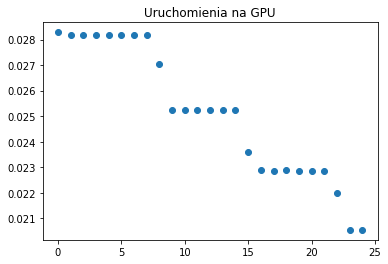



Średnia 0.02511252
Odchylenie standardowe 0.0025564997652258847
Min 0.020543
Max 0.028287


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

gpu_result_vector = np.array([0.028287, 0.028171, 0.028174, 0.028170, 0.028171, 0.028171, 0.028173, 0.028183, 0.027027, 0.025234, 0.025233, 0.025231, 0.025242, 0.025230, 0.025243, 0.023576, 0.022871, 0.022868, 0.022871, 0.022863, 0.022865, 0.022860, 0.022006, 0.020550, 0.020543])
plt.title("Uruchomienia na GPU")
plt.plot(range(0, len(gpu_result_vector)), gpu_result_vector, 'o', )
plt.show()
print("\n")
print(f"Średnia {gpu_result_vector.mean()}")
print(f"Odchylenie standardowe {gpu_result_vector.std()}")
print(f"Min {gpu_result_vector.min()}")
print(f"Max {gpu_result_vector.max()}")

**Wnioski**

Wersja CPU charakteryzuje się dużo mniejszą wydajnością w porównaniu do uruchomień na GPU. Dodatkowo możemy zauważyć, że uruchomienia w CPU są bardziej rozrzucone natomiast każde uruchomienie GPU albo przypomina poprzednie albo jest od poprzedniego szybsze. 